In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.573878496271703

R-squared complex model:
0.573973445205822

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.864]
 [-0.001 553434.239]]


/Users/majic/.local/share/virtualenvs/thinkful-py3-eTaMB5Ia/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [3]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))


R-squared simple model:
0.5630697922503317

R-squared complex model:
0.563023952731933


In [4]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613363

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


In [5]:
print(ridgeregr.score(X_test, Y_test))
print(ridgeregrBig.score(X_test2, Y_test))

0.5631088763076704
0.5631804323930898


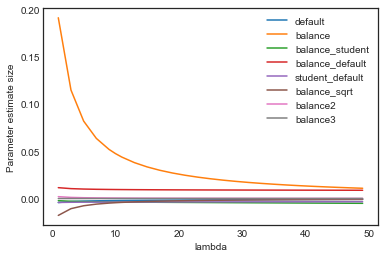

In [6]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()